In [10]:
import matplotlib.pyplot as plt
from stompy.grid import unstructured_grid 
from stompy import utils
import xarray as xr
import os, glob
import numpy as np
%matplotlib notebook

In [11]:
hourly_ncs=glob.glob('hourly-out-v01/surface*.nc')
hourly_ncs.sort()
len(hourly_ncs)

7728

In [12]:
# Experiment level configuration -- small, all python native data.
# The 'new' run
cfg=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022b",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
cfg['ptm_run_patt']=os.path.join(cfg['ptm_base_dir'],"chunk??","20??????")
cfg['sun_patt']=os.path.join(cfg['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(cfg['ptm_run_patt'])
ptm_run_paths.sort()
cfg['ptm_run_paths']=ptm_run_paths

sun_paths=glob.glob(cfg['sun_patt'])
sun_paths.sort()
cfg['sun_paths']=sun_paths
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [13]:
Msmooth=grid.smooth_matrix()

INFO:utils:47745/99089
INFO:utils:97695/99089


In [14]:
# Apply godin filter
import postproc_dask as post

In [15]:
win=post.godwin
win=win[win>0.0]
len(win)

71

In [16]:
def filter_stream(fns,win,stride=24):
    N=len(win)
    # Load the first set:
    idx=0 # index of the next unread step
    dss=[]

    while 1:
        # Load enough to get to N:
        while len(dss)<N:
            if idx==len(fns):
                return
            dss.append(xr.open_dataset(fns[idx]))
            idx+=1
        
        # Calculate the average:
        out=np.zeros(dss[0].dims['cell'],np.float64)

        for weight,ds in zip(win,dss):
            out += ds.conc.values * weight
        ds_out=dss[0].copy()
        ds_out['conc']=('cell',),out
        ds_out['time']=(),dss[N//2].time.values
        ds_out['time_min']=(),dss[0].time.values
        ds_out['time_max']=(),dss[-1].time.values
        yield ds_out
        
        stale=dss[:stride]
        for ds in stale:
            ds.close()
        dss=dss[stride:]
        if stride>N:
            idx+=(stride-N)


In [17]:
import conc_figure
from matplotlib import cm
import stompy.plot.cmap as scmap
cmap=cm.CMRmap_r

cmap=scmap.cmap_clip(cmap,0.08,1)

<IPython.core.display.Javascript object>


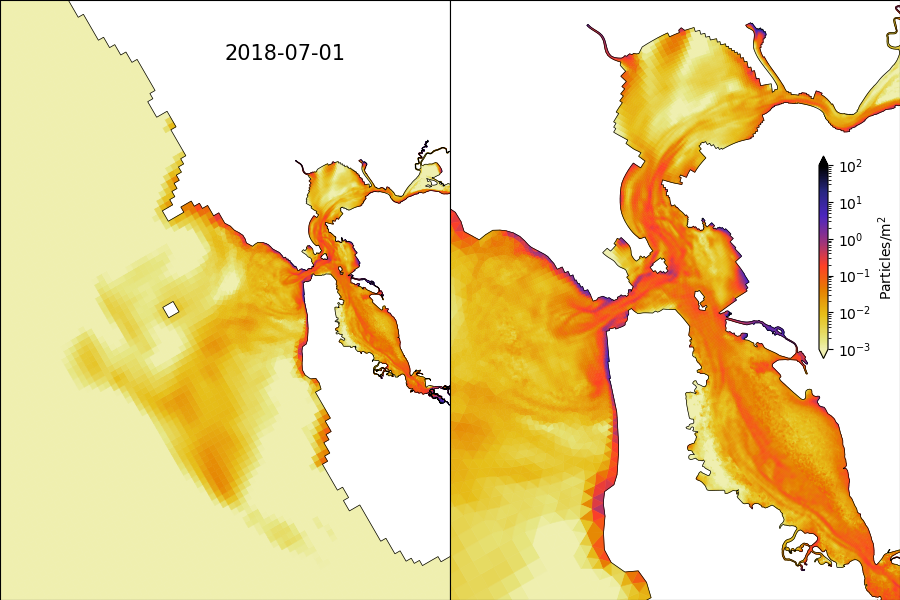

In [18]:
fig,axs=plt.subplots(1,2,figsize=(9,6))

In [19]:
storm_factor=0.02
tau_d=30

# v03: regenerate with standardized colormap and
#  limited to 'valid' period of PTM output.
frame_dir="surface-frames-v04"
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)
    
for i,ds_conc in enumerate(filter_stream(hourly_ncs,win,stride=8)):
    #if ds_conc.time.values > np.datetime64("2018-04-26"):
    #    print("Hit end of currently valid PTM output")
    #    break
    fig_fn=os.path.join(frame_dir,
                         f"conc-storm{storm_factor}-tau{tau_d}-{i:04d}.png")
    if os.path.exists(fig_fn):
        continue
    
    ds_smooth=ds_conc.copy()
    # 2 iterations seems good for removing particle noise
    for _ in range(2):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)

    fig.clf()
    axs=[fig.add_subplot(1,2,1),
         fig.add_subplot(1,2,2)]
    
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0)

    kws=dict(grid=grid,grid_poly=grid_poly,fig=fig,cmap=cmap)             
    cf1=conc_figure.BayConcFigure(ds_smooth, ax=axs[1], 
                                  cax_loc=[0.82,0.37,0.02,0.45],
                                  **kws)
    cf2=conc_figure.CoastalConcFigure(ds_smooth,ax=axs[0],
                                      cax_loc=None,
                                      **kws)
    for ax in axs:
        ax.texts=[]

    date_s=utils.to_datetime(ds_conc.time.values).strftime("%Y-%m-%d")
    axs[0].text(0.5,0.9,date_s,transform=axs[0].transAxes,fontsize=15)
    axs[0].axis([441742., 591985., 4076042., 4276366.])
    axs[1].axis([522130., 582108., 4146136, 4226106.])
    plt.draw()
    fig.savefig(fig_fn,dpi=120)
    plt.pause(0.01)


<IPython.core.display.Javascript object>


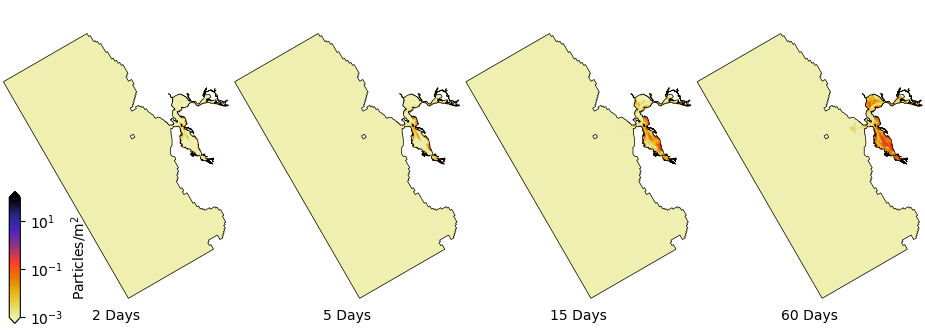

In [22]:
# Show reach of particles over time:
out_dir="snapshots-v00"

conc_fns=glob.glob(os.path.join(out_dir,'*.nc'))
conc_fns.sort()

for conc_fn in conc_fns:
    fig_fn=conc_fn.replace('.nc','.png')
    #if os.path.exists(fig_fn): continue
    
    ds=xr.open_dataset(conc_fn)

    ages=[2,5,15,60]

    fig,axs=plt.subplots(1,len(ages),figsize=(9.25,3.3))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0)
    fig.canvas.draw()

    kws=dict(fig=fig,grid=grid,grid_poly=grid_poly,cmap=cmap,
             cax_loc=[0.05,0.05,0.04,0.45])

    plots=[]
    for ax,age_max in zip(axs,ages):
        ds_sel=ds.sel(age_max=age_max)    
        p=conc_figure.CoastalConcFigure(ds_sel,ax=ax,**kws)
        plots.append(p)
        kws['cax_loc']=None
        ax.texts=[]
        plt.setp(list(ax.spines.values()),visible=0)
        ax.text(0.5,0.02,"%d Days"%age_max,ha='center',va='bottom',
                transform=ax.transAxes)
    plots[0].cax.set_position([0.01,0.02,0.012,0.4])

    fig.savefig(fig_fn,dpi=200)
    ds.close()
    break

In [ ]:
ls snapshots-v00